In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType, DateType, DoubleType
from pyspark.sql import functions
import math

In [3]:
spark = SparkSession \
    .builder \
    .appName("airlinedelay") \
    .getOrCreate()

context = spark.sparkContext

23/01/01 10:48:28 WARN Utils: Your hostname, lucian resolves to a loopback address: 127.0.1.1; using 192.168.100.7 instead (on interface eno1)
23/01/01 10:48:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/01 10:48:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
schema = StructType([
    StructField("FL_DATE", DateType(), True),
    StructField("OP_CARRIER", StringType(), True),
    StructField("OP_CARRIER_FL_NUM", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("CRS_DEP_TIME", DoubleType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", DoubleType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("CARRIER_DELAY", DoubleType(), True),
    StructField("WEATHER_DELAY", DoubleType(), True),
    StructField("NAS_DELAY", DoubleType(), True),
    StructField("SECURITY_DELAY", DoubleType(), True),
    StructField("LATE_AIRCRAFT_DELAY", DoubleType(), True)
])

df = spark.read.format("csv") \
    .option("sep", ",") \
    .option("header", True) \
    .schema(schema) \
    .load("*.csv")

df.createOrReplaceTempView("airlinedelay")

23/01/01 10:48:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CORRELATION BETWEEN DEPARTURE DELAY AND ARRIVAL DELAY

In [11]:
df.stat.corr('DEP_DELAY', 'ARR_DELAY')

0.9382029931731353

GENERAL EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS

In [24]:
evolutionAverageDelaysPerYear = spark.sql("SELECT EXTRACT(year from FL_DATE) AS Year, AVG(IF(DEP_DELAY > 0, DEP_DELAY, NULL)) AS AverageDepartureDelayPerYear, AVG(IF(DEP_DELAY < 0, DEP_DELAY, NULL)) AS AverageDepartureImmediacyPerYear, AVG(IF(ARR_DELAY > 0, ARR_DELAY, NULL)) AS AverageArrivalDelayPerYear, AVG(IF(ARR_DELAY < 0, ARR_DELAY, NULL)) AS AverageArrivalImmediacyPerYear \
    FROM airlinedelay \
    GROUP BY Year") \
    
evolutionAverageDelaysPerYear.show()

+----+----------------------------+--------------------------------+--------------------------+------------------------------+
|Year|AverageDepartureDelayPerYear|AverageDepartureImmediacyPerYear|AverageArrivalDelayPerYear|AverageArrivalImmediacyPerYear|
+----+----------------------------+--------------------------------+--------------------------+------------------------------+
|2012|          29.308491558603826|              -4.775003687415096|         30.01057264950832|           -12.005357641941504|
|2013|          31.401555361002433|              -4.904385394290586|        31.827785050297418|           -11.702265936434728|
|2014|           32.49641736820618|              -4.833083676692695|        32.533315365395346|           -11.405155103231625|
+----+----------------------------+--------------------------------+--------------------------+------------------------------+



GENERAL EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS \[GRAPHS\]

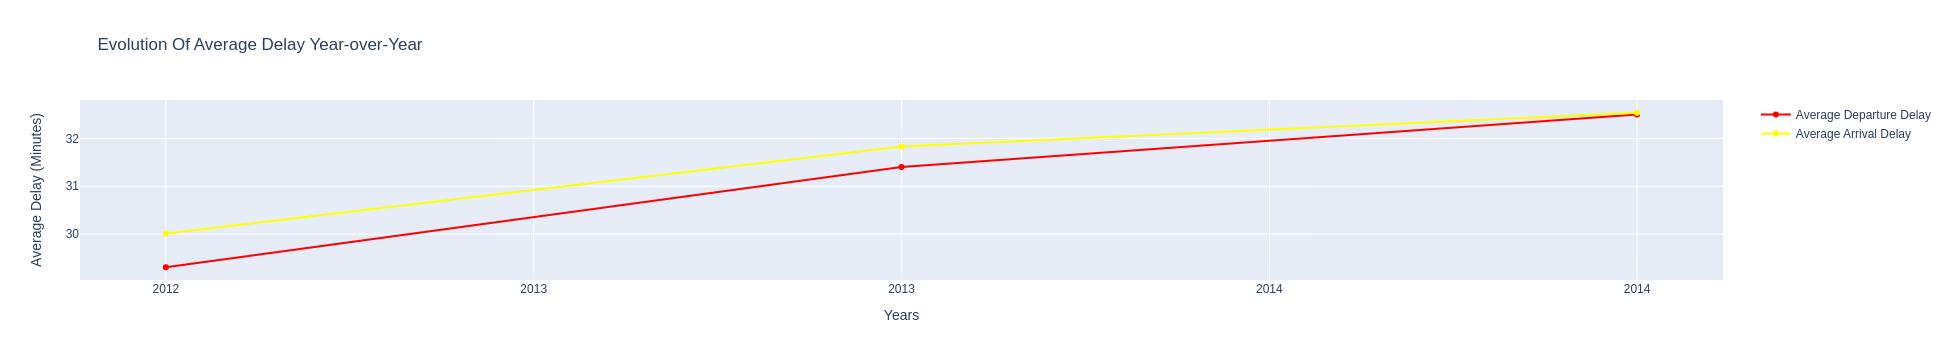

In [59]:
averageDepartureDelayPerYearTrace = go.Scatter(
    y = evolutionAverageDelaysPerYear.toPandas()['AverageDepartureDelayPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Departure Delay',
    marker = dict(color='red'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

averageArrivalDelayPerYearTrace = go.Scatter(
    y = evolutionAverageDelaysPerYear.toPandas()['AverageArrivalDelayPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Arrival Delay',
    marker = dict(color='yellow'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

data = [averageDepartureDelayPerYearTrace, averageArrivalDelayPerYearTrace]

layout = dict(title = 'Evolution Of Average Delay Year-over-Year',
              xaxis= dict(title= 'Years',ticklen= 5,zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Average Delay (Minutes)')
             )
fig = dict(data = data, layout = layout)

pyo.iplot(fig)

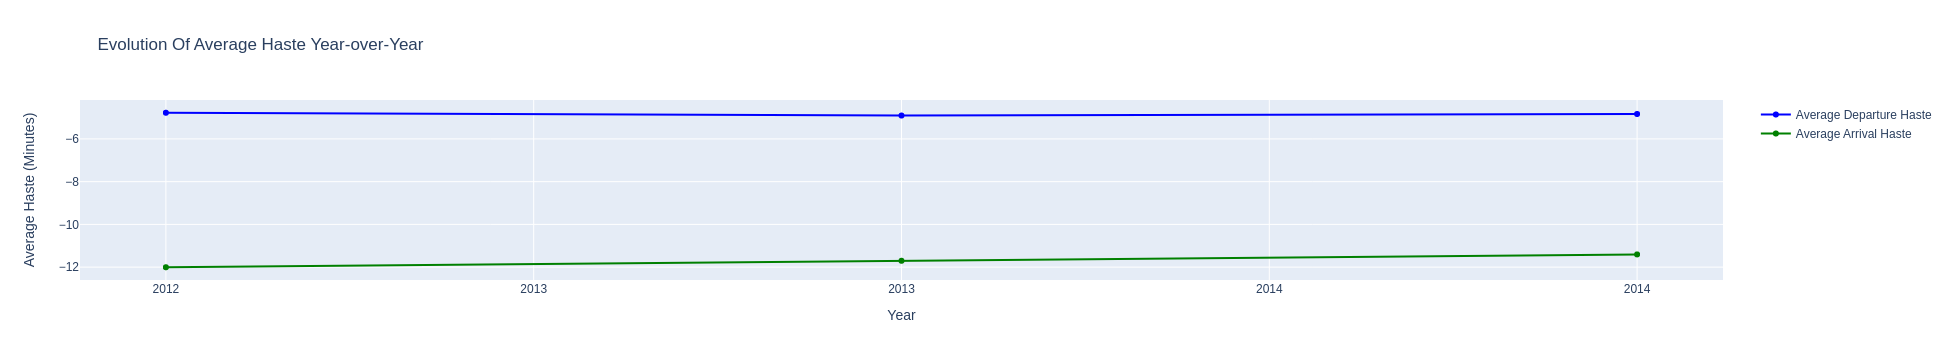

In [60]:
averageDepartureImmediacyPerYearTrace = go.Scatter(
    y= evolutionAverageDelaysPerYear.toPandas()['AverageDepartureImmediacyPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Departure Haste',
    marker = dict(color='blue'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

averageArrivalImmediacyPerYearTrace = go.Scatter(
    y = evolutionAverageDelaysPerYear.toPandas()['AverageArrivalImmediacyPerYear'],
    x = evolutionAverageDelaysPerYear.toPandas()['Year'],
    mode = 'lines+markers',
    name = 'Average Arrival Haste',
    marker = dict(color='green'),
    text = evolutionAverageDelaysPerYear.toPandas()['Year'])

data = [averageDepartureImmediacyPerYearTrace, averageArrivalImmediacyPerYearTrace]

layout = dict(title = 'Evolution Of Average Haste Year-over-Year',
              xaxis= dict(title= 'Year',ticklen= 5,zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Average Haste (Minutes)')
             )
fig = dict(data = data, layout = layout)

pyo.iplot(fig)

AVERAGE DEPARTURE/ARRIVAL DELAYS AND IMMEDIACIES FOR EACH CARRIER

In [6]:
spark.sql("SELECT OP_CARRIER AS Carrier, AVG(IF(DEP_DELAY > 0, DEP_DELAY, NULL)) AS AverageDepartureDelayPerYear, AVG(IF(DEP_DELAY < 0, DEP_DELAY, NULL)) AS AverageDepartureImmediacyPerYear, AVG(IF(ARR_DELAY > 0, ARR_DELAY, NULL)) AS AverageArrivalDelayPerYear, AVG(IF(ARR_DELAY < 0, ARR_DELAY, NULL)) AS AverageArrivalImmediacyPerYear \
    FROM airlinedelay \
    GROUP BY OP_CARRIER \
    ORDER BY OP_CARRIER") \
    .show(1000)

+-------+----------------------------+--------------------------------+--------------------------+------------------------------+
|Carrier|AverageDepartureDelayPerYear|AverageDepartureImmediacyPerYear|AverageArrivalDelayPerYear|AverageArrivalImmediacyPerYear|
+-------+----------------------------+--------------------------------+--------------------------+------------------------------+
|     9E|            41.1994042994043|              -5.564889633425305|         35.87002260292782|           -13.436900873769936|
|     AA|           32.54444204760743|              -4.700877399716953|        33.255888586969014|           -12.431163678020225|
|     AS|          25.501613592356573|              -6.637907372005587|         21.63877411823345|            -12.85842735530121|
|     B6|          38.235298232523434|              -5.639004307460789|         37.05889731902625|           -13.144293274691284|
|     DL|          29.328027779297397|              -4.020968669531213|         29.3424858

EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS PER CARRIER FOR EACH YEAR

In [8]:
carrierDelayEvolution = spark.sql("SELECT OP_CARRIER AS Carrier, EXTRACT(year from FL_DATE) AS Year, AVG(IF(DEP_DELAY > 0, DEP_DELAY, NULL)) AS AverageDepartureDelayPerYear, AVG(IF(DEP_DELAY < 0, DEP_DELAY, NULL)) AS AverageDepartureImmediacyPerYear, AVG(IF(ARR_DELAY > 0, ARR_DELAY, NULL)) AS AverageArrivalDelayPerYear, AVG(IF(ARR_DELAY < 0, ARR_DELAY, NULL)) AS AverageArrivalImmediacyPerYear \
    FROM airlinedelay \
    GROUP BY OP_CARRIER, Year  \
    ORDER BY OP_CARRIER, Year")

carrierDelayEvolution.show(1000)

+-------+----+----------------------------+--------------------------------+--------------------------+------------------------------+
|Carrier|Year|AverageDepartureDelayPerYear|AverageDepartureImmediacyPerYear|AverageArrivalDelayPerYear|AverageArrivalImmediacyPerYear|
+-------+----+----------------------------+--------------------------------+--------------------------+------------------------------+
|     9E|2013|            41.1994042994043|              -5.564889633425305|         35.87002260292782|           -13.436900873769936|
|     AA|2012|            31.9744497812039|              -4.552307015030712|        31.822441532976004|            -12.59330599656538|
|     AA|2013|           30.80871770776232|              -4.624880325958691|         33.37034777594022|           -12.778652352657465|
|     AA|2014|          35.007743983428355|              -4.912890145205526|        34.518669487146646|           -11.904497881883877|
|     AS|2012|          27.879336977186313|            

In [9]:
carrierDelayEvolution.createOrReplaceTempView("carrierDelayEvolution")

EVOLUTION OF DELAYS/IMMEDIACIES FOR DEPARTURES AND ARRIVALS PER CARRIER FOR EACH YEAR: absolute change YoY of average departure/arrival delays/immediacies 

*Note: negative => immediacy decreases, plane leaves on time; positive => immediacy increases, plane does not leave on time.*

In [10]:
spark.sql(" \
    SELECT Carrier, Year, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), AverageDepartureDelayPerYear - LAG(AverageDepartureDelayPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageDepartureDelayYearOverYearDifference, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), - AverageDepartureImmediacyPerYear + LAG(AverageDepartureImmediacyPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageDepartureImmediacyYearOverYearDifference, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), AverageArrivalDelayPerYear - LAG(AverageArrivalDelayPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageArrivalDelayYearOverYearDifference, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), - AverageArrivalImmediacyPerYear + LAG(AverageArrivalImmediacyPerYear) OVER (ORDER BY Carrier, Year), NULL) AS AverageArrivalImmediacyYearOverYearDifference \
    FROM carrierDelayEvolution") \
    .na.drop('any') \
    .show(1000)

23/01/01 10:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:48:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/01 10:48:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:48:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:48:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:48:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:48:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:48:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------+-

PERCENTAGE OF DELAYS/IMMEDIACIES ON DELAYS/ARRIVALS PER CARRIER FOR ENTIRE PERIOD RELATIVE TO ALL FLIGHTS FOR CURRENT CARRIER

In [66]:
numberOfDelaysPerCarrier = spark.sql(" \
    SELECT OP_CARRIER AS Carrier, \
    SUM( \
          CASE WHEN DEP_DELAY > 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS DepartureDelayCount, \
    SUM( \
          CASE WHEN ARR_DELAY > 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS ArrivalDelayCount, \
    SUM( \
          CASE WHEN DEP_DELAY < 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS DepartureImmediaciesCount, \
    SUM( \
          CASE WHEN ARR_DELAY < 0 THEN 1 \
          ELSE 0 END \
    ) / COUNT(*) AS ArrivalImmediaciesCount \
    FROM airlinedelay \
    GROUP BY Carrier")

numberOfDelaysPerCarrier.show(1000)

+-------+-------------------+-------------------+-------------------------+-----------------------+
|Carrier|DepartureDelayCount|  ArrivalDelayCount|DepartureImmediaciesCount|ArrivalImmediaciesCount|
+-------+-------------------+-------------------+-------------------------+-----------------------+
|     UA|0.49265078196307127|0.38583117019726626|      0.43628488975682933|     0.5794033729895575|
|     AA|0.39963068650331585| 0.4076010364765793|       0.5327690766163088|     0.5491283152008236|
|     EV| 0.3651398344895044|0.38786443289396993|       0.5648748926719043|      0.557476378625943|
|     B6| 0.3571224355540258|0.38944743145979466|       0.5828644629062657|      0.574316540971457|
|     DL|0.30440014654300496|0.31626688706547634|       0.6240685491716639|     0.6540809422224404|
|     OO| 0.3052583400865307| 0.3814990213472831|       0.6264621233129346|     0.5658852701323807|
|     F9|0.44534640365147854| 0.5145314365838538|       0.5008591958925027|     0.4511007277160368|


PERCENTAGE OF DELAYS/IMMEDIACIES ON DELAYS/ARRIVALS PER CARRIER FOR ENTIRE PERIOD RELATIVE TO ALL FLIGHTS FOR CURRENT CARRIER \[GRAPHS\]

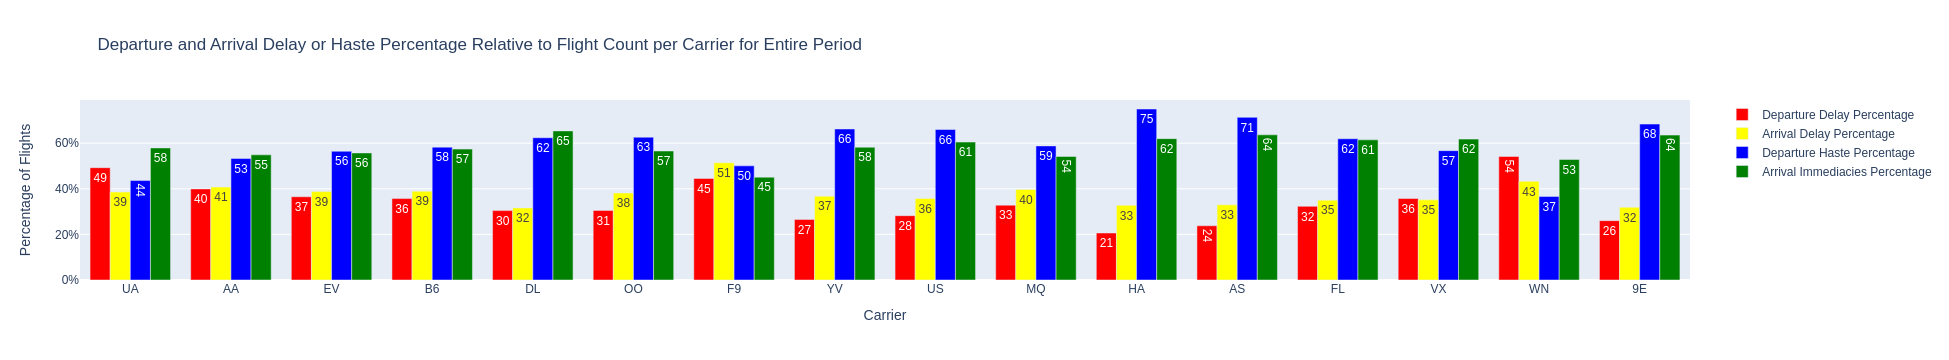

In [88]:
departureDelayCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['DepartureDelayCount'],
    name = 'Departure Delay Percentage',
    marker = dict(color='red'),
    text = round(numberOfDelaysPerCarrier.toPandas()['DepartureDelayCount'] * 100))

arrivalDelayCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['ArrivalDelayCount'],
    name = 'Arrival Delay Percentage',
    marker = dict(color='yellow'),
    text = round(numberOfDelaysPerCarrier.toPandas()['ArrivalDelayCount'] * 100))

departureImmediaciesCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['DepartureImmediaciesCount'],
    name = 'Departure Haste Percentage',
    marker = dict(color='blue'),
    text = round(numberOfDelaysPerCarrier.toPandas()['DepartureImmediaciesCount'] * 100))

arrivalImmediaciesCountBar = go.Bar(
    x = numberOfDelaysPerCarrier.toPandas()['Carrier'],
    y = numberOfDelaysPerCarrier.toPandas()['ArrivalImmediaciesCount'],
    name = 'Arrival Immediacies Percentage',
    marker = dict(color='green'),
    text = round(numberOfDelaysPerCarrier.toPandas()['ArrivalImmediaciesCount'] * 100))


data = [departureDelayCountBar, arrivalDelayCountBar, departureImmediaciesCountBar, arrivalImmediaciesCountBar]

layout = dict(title = 'Departure and Arrival Delay or Haste Percentage Relative to Flight Count per Carrier for Entire Period',
              xaxis= dict(title= 'Carrier',ticklen= 5,zeroline= False,tickformat='d'),
              yaxis= dict(title= 'Percentage of Flights',tickformat=',.0%')
             )
fig = dict(data = data, layout = layout)

pyo.iplot(fig)

DELAY CORRECTIONS COUNT PER CARRIER ACROSS THE ENTIRE PERIOD

In [12]:
totalDelayCorrectionsCount = spark.sql(" \
    SELECT OP_CARRIER AS Carrier, \
    SUM( \
          CASE WHEN DEP_DELAY = ARR_DELAY THEN 1 \
          ELSE 0 END \
    ) AS NoDelayCorrectionCount, \
    SUM( \
          CASE WHEN ARR_DELAY = (DEP_DELAY * -1) THEN 1 \
          ELSE 0 END \
    ) AS FullDelayCorrectionCount, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY < DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY > DEP_DELAY) THEN 1 \
          ELSE 0 END \
    ) AS PartialDelayCorrectionCount, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY > DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY < 0 AND ABS(DEP_DELAY) < ABS(ARR_DELAY)) THEN 1 \
          ELSE 0 END \
    ) AS DelayAggravationCount \
    FROM airlinedelay \
    GROUP BY Carrier")
    
totalDelayCorrectionsCount.show(1000)

+-------+----------------------+------------------------+---------------------------+---------------------+
|Carrier|NoDelayCorrectionCount|FullDelayCorrectionCount|PartialDelayCorrectionCount|DelayAggravationCount|
+-------+----------------------+------------------------+---------------------------+---------------------+
|     UA|                 34476|                   22189|                     698433|               686956|
|     AA|                 49519|                   24718|                     675036|               764743|
|     EV|                 67734|                   25855|                     845345|              1105402|
|     B6|                 20909|                    9127|                     292921|               362491|
|     DL|                 65363|                   34966|                     841308|              1212324|
|     OO|                 75483|                   29307|                     759293|               893194|
|     F9|                 11

EVOLUTION OF DELAY CORRECTIONS COUNT PER CARRIER ACROSS INDIVIDUAL YEARS

In [14]:
carrierDelayCountEvolution = spark.sql(" \
    SELECT OP_CARRIER AS Carrier, EXTRACT(year from FL_DATE) AS Year, \
    SUM( \
          CASE WHEN DEP_DELAY = ARR_DELAY THEN 1 \
          ELSE 0 END \
    ) AS NoDelayCorrectionCount, \
    SUM( \
          CASE WHEN ARR_DELAY = (DEP_DELAY * -1) THEN 1 \
          ELSE 0 END \
    ) AS FullDelayCorrectionCount, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY < DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY > DEP_DELAY) THEN 1 \
          ELSE 0 END \
    ) AS PartialDelayCorrectionCount, \
    SUM( \
          CASE WHEN (DEP_DELAY > 0 AND ARR_DELAY > DEP_DELAY) OR (DEP_DELAY < 0 AND ARR_DELAY < 0 AND ABS(DEP_DELAY) < ABS(ARR_DELAY)) THEN 1 \
          ELSE 0 END \
    ) AS DelayAggravationCount \
    FROM airlinedelay \
    GROUP BY Carrier, Year \
    ORDER BY Carrier, Year")
    
carrierDelayCountEvolution.createOrReplaceTempView("carrierDelayCountEvolution")
carrierDelayCountEvolution.show(1000)

+-------+----+----------------------+------------------------+---------------------------+---------------------+
|Carrier|Year|NoDelayCorrectionCount|FullDelayCorrectionCount|PartialDelayCorrectionCount|DelayAggravationCount|
+-------+----+----------------------+------------------------+---------------------------+---------------------+
|     9E|2013|                  8652|                    3455|                     103688|               167066|
|     AA|2012|                 16846|                    8497|                     213715|               256040|
|     AA|2013|                 14734|                    8102|                     235310|               248273|
|     AA|2014|                 17939|                    8119|                     226011|               260430|
|     AS|2012|                  5428|                    2072|                      56717|                77788|
|     AS|2013|                  6137|                    2696|                      68682|      

EVOLUTION OF DELAY CORRECTIONS COUNT PER CARRIER ACROSS INDIVIDUAL YEARS: YoY absolute change for each carrier per year

In [15]:
spark.sql(" \
    SELECT Carrier, Year, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), NoDelayCorrectionCount - LAG(NoDelayCorrectionCount) OVER (ORDER BY Carrier, Year), NULL) AS NoDelayCorrectionCountYoY, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), FullDelayCorrectionCount - LAG(FullDelayCorrectionCount) OVER (ORDER BY Carrier, Year), NULL) AS FullDelayCorrectionCountYoY, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), PartialDelayCorrectionCount - LAG(PartialDelayCorrectionCount) OVER (ORDER BY Carrier, Year), NULL) AS PartialDelayCorrectionCountYoY, \
    IF(Carrier = LAG(Carrier) OVER (ORDER BY Carrier, Year), DelayAggravationCount - LAG(DelayAggravationCount) OVER (ORDER BY Carrier, Year), NULL) AS DelayAggravationCountYoY \
    FROM carrierDelayCountEvolution") \
    .na.drop('any') \
    .show(1000)

23/01/01 10:49:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:49:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:49:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


23/01/01 10:49:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:49:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:49:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:49:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:49:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/01 10:49:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------+-